In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import DistanceMetric
from math import radians
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx
from gurobipy import *

In [2]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [3]:
# Number of Candidate DCs
DC_N = 3

# List Creator for DCs
def createList_DC(r1, r2):
    return list(['DC%d'%x for x in range(r1, r2+1)])

#create an index
DC_ID = createList_DC(1, DC_N)

#Gi = fixed cost for establishing depot i
fixed_cost_DC = [1500] * DC_N 

#Maximum Throughput at depot i = Vi
capacity_DC = [100] * DC_N

#Variable Warehousing Cost (Picking)
varCost_DC = [12, 15, 20, 30]

#Position of the DCs
lat_DC = [49.794783, 49.794606, 49.7881377, 49.8226541]
lon_DC = [9.906499, 9.944346, 9.9314981, 9.9245535]

dc_tuples = list(zip(DC_ID, fixed_cost_DC, capacity_DC, varCost_DC, lat_DC, lon_DC))

set_of_all_DC = pd.DataFrame(dc_tuples, columns = ["DC_ID", "fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon"])
set_of_all_DC.set_index("DC_ID", inplace = True)

# Define I
I = set_of_all_DC.index.values
I

set_of_all_DC

,fixed_cost_DC,capacity_DC,varCost_DC,lat,lon
DC_ID,,,,,
DC1,1500,100,12,49.794783,9.906499
DC2,1500,100,15,49.794606,9.944346
DC3,1500,100,20,49.788138,9.931498


In [36]:
# Sample Customers from osmnx

# Define Customer N and Demand per
customers = 40
demand_per_customer = 5

# Function to create a Customer Index List

def createList_C(r1, r2):
    return list(['C%d'%x for x in range(r1, r2+1)])

# Get all nodes in Würzburg from OSMNX which will be used to sample a certain amount of customers
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Create nodes_df which is the basis for our customer df
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]

#Sample from nodes_df
sample_nodes_df = nodes_df.sample(n = customers, random_state= 4)
Nodes_S = sample_nodes_df.index.values
# Create Nodes_S which will help in plotting the solutions within osmnx
Nodes_S.tolist()

#DF Manipulation
C_ID = createList_C(1,customers)
osmid = list(sample_nodes_df.index.values)
sample_nodes_df = sample_nodes_df.rename(index=dict(zip(osmid,C_ID)))
sample_nodes_df.index.name = "C_ID"

#Create final demand column for customer DF
mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
set_of_all_customers['Demand_C'] = mylist
J = set_of_all_customers.index.values
set_of_all_customers.head()

,lat,lon,Demand_C
C_ID,,,
C1,49.800625,9.914932,5
C2,49.804163,9.918820,5
C3,49.800478,9.933612,5
C4,49.786208,9.944269,5
C5,49.792946,9.930499,5


In [5]:
# Construct set of all vehicles K

#Vehicle Count
V_N = 2

# Vehicle List Creator
def createList_V(r1, r2):
    return list(['V_%d'%x for x in range(r1, r2+1)])

# create index
V_ID = createList_V(1, V_N)

# Vehicle Capacity Qk
capacity_V = [100] * V_N

# fixed cost of using Vehicle Fk
fixed_cost_V = [5] * V_N

v_tuples = list(zip(V_ID, capacity_V, fixed_cost_V))

set_of_all_vehicles = pd.DataFrame(v_tuples, columns = ["V_ID", "capacity_V", "fixed_cost_V"])
set_of_all_vehicles.set_index("V_ID", inplace=True)
K = set_of_all_vehicles.index.values
set_of_all_vehicles

,capacity_V,fixed_cost_V
V_ID,,
V_1,100,5
V_2,100,5


In [37]:
# Create a distance matrix with all DCs and Customers

# Concat the DC and Customer DF
DF = pd.concat([set_of_all_DC, set_of_all_customers], axis = 0)
DF = DF.drop(DF.columns[[0,1,2,5]], axis = 1)
DF['C_ID'] = DF.index

#Convert lat and lon in to radians
DF['lat'] = np.radians(DF['lat'])
DF['lon'] = np.radians(DF['lon'])

# Define dist parameter as haversine
dist = DistanceMetric.get_metric("haversine")
# Convert to numpy array
DF[["lat", "lon"]].to_numpy()

#Create the distance matrix py pairwise comparison
dist_matrix = pd.DataFrame(dist.pairwise(DF[["lat", "lon"]].to_numpy())*6378100, columns=DF.C_ID.unique(), index=DF.C_ID.unique())
dist_matrix = dist_matrix.round(1)
dist_matrix

,DC1,DC2,DC3,C1,C2,C3,C4,C5,C6,C7,...,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40
DC1,0.0,2719.7,1942.9,888.8,1369.0,2048.7,2877.3,1736.7,2812.8,3572.2,...,2159.3,2095.2,1826.4,849.0,1765.8,5789.3,1763.3,2982.5,1825.5,5920.0
DC2,2719.7,0.0,1170.9,2217.2,2120.3,1011.0,934.8,1012.1,2036.9,1786.4,...,3718.1,805.1,1582.4,1946.8,981.2,3106.1,1168.8,426.2,941.4,3229.0
DC3,1942.9,1170.9,0.0,1830.1,2003.1,1382.0,942.6,540.1,1223.2,1662.6,...,2550.1,375.3,1773.9,1435.0,543.8,4193.3,227.5,1219.5,486.3,4304.7
C1,888.8,2217.2,1830.1,0.0,482.9,1342.3,2649.5,1407.8,2958.6,3475.4,...,2939.0,1815.9,983.2,407.5,1427.7,5146.6,1605.7,2565.7,1503.8,5284.7
C2,1369.0,2120.3,2003.1,482.9,0.0,1139.2,2709.1,1504.4,3197.9,3580.0,...,3404.6,1897.4,635.5,758.6,1515.7,4883.1,1776.5,2511.2,1592.2,5025.5
C3,2048.7,1011.0,1382.0,1342.3,1139.2,0.0,1763.4,867.7,2574.4,2662.6,...,3589.9,1096.2,571.5,1200.6,853.7,3804.5,1211.4,1426.2,898.6,3942.4
C4,2877.3,934.8,942.6,2649.5,2709.1,1763.4,0.0,1241.8,1194.7,899.1,...,3273.5,833.7,2301.0,2285.5,1222.2,3436.0,1115.2,631.7,1145.8,3532.0
C5,1736.7,1012.1,540.1,1407.8,1504.4,867.7,1241.8,0.0,1762.5,2083.3,...,2824.6,408.2,1234.0,1050.8,30.9,4117.7,345.4,1245.9,96.6,4241.0
C6,2812.8,2036.9,1223.2,2958.6,3197.9,2574.4,1194.7,1762.5,0.0,1083.1,...,2385.3,1480.8,2996.4,2551.2,1764.2,4528.2,1438.5,1817.8,1700.9,4609.0
C7,3572.2,1786.4,1662.6,3475.4,3580.0,2662.6,899.1,2083.3,1083.1,0.0,...,3466.0,1682.9,3197.3,3090.3,2068.7,3581.7,1877.8,1399.2,1991.6,3645.9


In [7]:
m = Model()

Academic license - for non-commercial use only - expires 2021-11-24
Using license file C:\Users\michi\gurobi.lic


In [8]:
x = m.addVars([*I,*J],[*I,*J],K, name = "x", vtype=GRB.BINARY)

In [9]:
y = m.addVars(I, name = "y", vtype = GRB.BINARY)

In [10]:
z = m.addVars(I,J, name = "z", vtype = GRB.BINARY)

In [11]:
U = [(l,k) for l in J for k in K]
u = m.addVars(U, name = "u", vtype= GRB.CONTINUOUS)

In [38]:
m.update()

In [13]:
fixedCost_depot = quicksum(y[i] * set_of_all_DC.loc[i].fixed_cost_DC for i in I)

In [14]:
variableCosts_transp = quicksum([x[i,j,k] * dist_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])

In [15]:
variableCosts_DC = quicksum(set_of_all_DC.loc[i].varCost_DC * z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J for i in I)

In [16]:
fixedCost_vehicle = quicksum(x[i,j,k] * set_of_all_vehicles.loc[k].fixed_cost_V for i in [*I,*J] for j in [*I,*J] for k in K if i!=j)

In [17]:
obj = fixedCost_depot + variableCosts_transp + variableCosts_DC + fixedCost_vehicle

In [18]:
m.setObjective(obj, GRB.MINIMIZE)

In [19]:
for j in J:
    m.addConstr(quicksum(x[i,j,k] for i in [*I,*J] for k in K if i!=j) == 1)

In [20]:
for k in K:
    m.addConstr(quicksum(set_of_all_customers.loc[j].Demand_C * x[i,j,k] for i in [*I,*J] for j in J if i!=j) <= set_of_all_vehicles.loc[k].capacity_V)

In [21]:
for l in J:
    for j in J:
        if l!=j:
            for k in K:
                m.addConstr(u[l,k] - u[j,k] + (len(set_of_all_customers) * x[l,j,k]) <= len(set_of_all_customers) -1)

In [22]:
for i in [*I,*J]:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in [*I,*J] if i!=j) - quicksum(x[j,i,k] for j in [*I,*J] if i!=j) == 0)

In [23]:
for k in K:
    m.addConstr(quicksum(x[i,j,k] for i in I for j in J) <= 1)

In [24]:
for i in I:
    m.addConstr(quicksum(z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J) - (set_of_all_DC.loc[i].capacity_DC * y[i]) <= 0)

In [25]:
for i in I:
    for j in J:
        for k in K:
            m.addConstr(quicksum(x[i,u,k] + x[u,j,k] for u in [*I,*J]) - z[i,j] <= 1)

In [26]:
#m.Params.MIPGap = 0.1
#m.Params.TimeLimit = 300

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [27]:
m.update()

In [27]:
m.write("LRP.lp")

In [28]:
#m.tune()


Solving model using baseline parameter set with TimeLimit=300s

Testing candidate parameter set 1...

	MIPGap 0.1 (fixed)

Solving with random seed #1 ...
Optimize a model with 1042 rows, 1260 columns and 12900 nonzeros
Model fingerprint: 0xc93964fb
Variable types: 42 continuous, 1218 integer (1218 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [6e+01, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 62600.400000
Presolve removed 0 rows and 48 columns
Presolve time: 0.01s
Presolved: 1042 rows, 1212 columns, 12648 nonzeros
Variable types: 42 continuous, 1170 integer (1170 binary)

Root relaxation: objective 2.212930e+04, 85 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 22129.3000    0   44 62600.4000 22129.3000  64.6%     -    0s
H    0     0    

In [ ]:
m.tune()
  for i in range(m.tuneResultCount):
    m.getTuneResult(i)
    m.write('tune'+str(i)+'.prm')

In [30]:
m.write("LRP_Tune.prm")

In [31]:
m.getTuneResult()

TypeError: getTuneResult() takes exactly 2 positional arguments (1 given)

In [39]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1042 rows, 1260 columns and 12900 nonzeros
Model fingerprint: 0xc93964fb
Variable types: 42 continuous, 1218 integer (1218 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [6e+01, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolved: 1042 rows, 1212 columns, 12648 nonzeros

Continuing optimization...


Cutting planes:
  Learned: 8
  Gomory: 27
  Cover: 43
  Clique: 3
  MIR: 36
  Flow cover: 213
  Inf proof: 8
  Zero half: 34
  RLT: 62

Explored 150905 nodes (2458221 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 31579.1 32095.5 32266.9 ... 35066.2

Optimal solution found (tolerance 1.00e-01)
Best objective 3.157910000000e+04, best bound 2.842270000000e+04, gap 9.9952%


In [33]:
m.printAttr("x")


    Variable            x 
-------------------------
x[DC1,C20,V_2]            1 
x[DC3,C19,V_1]            1 
x[C1,DC1,V_2]            1 
x[C2,C16,V_2]            1 
x[C3,C15,V_2]            1 
x[C4,C8,V_2]            1 
x[C5,C10,V_2]            1 
x[C6,C13,V_2]            1 
x[C7,C4,V_2]            1 
x[C8,C17,V_2]            1 
x[C9,C3,V_2]            1 
x[C10,C2,V_2]            1 
x[C11,C12,V_2]            1 
x[C12,C6,V_2]            1 
x[C13,C7,V_2]            1 
x[C14,C11,V_2]            1 
x[C15,C5,V_2]            1 
x[C16,C1,V_2]            1 
x[C17,C21,V_2]            1 
x[C18,C9,V_2]            1 
x[C19,DC3,V_1]            1 
x[C20,C14,V_2]            1 
x[C21,C18,V_2]            1 
      y[DC1]            1 
      y[DC3]            1 
   z[DC1,C1]            1 
   z[DC1,C2]            1 
   z[DC1,C3]            1 
   z[DC1,C4]            1 
   z[DC1,C5]            1 
   z[DC1,C6]            1 
   z[DC1,C7]            1 
   z[DC1,C8]            1 
   z[DC1,C9]            1 


In [34]:
# DC Printer
print("The following DCs are established:")
for i in I:
    if y[i].X >= 0.1:
        print("-{}".format(set_of_all_DC.loc[i].name))

The following DCs are established:
-DC1
-DC3


In [35]:
# new cost printer
fixedC = sum([y[i].X * set_of_all_DC.loc[i].fixed_cost_DC for i in I])
varC = sum([x[i,j,k].X *  dist_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])
#fixedCV = sum([x[i,j,k].X * set_of_all_vehicles.loc[k].fixed_cost_V  for i,j,k in R])
varDC = sum(set_of_all_DC.loc[i].varCost_DC * z[i,j].X * set_of_all_customers.loc[j].Demand_C for j in J for i in I)
print("Distance traveled: {}m \nFixed Costs for Depots: {}€ \n Variable Warehousing Cost {}€".format(varC, fixedC, varDC))

Distance traveled: 27164.100000000006m 
Fixed Costs for Depots: 3000.0€ 
 Variable Warehousing Cost 1300.0€


C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


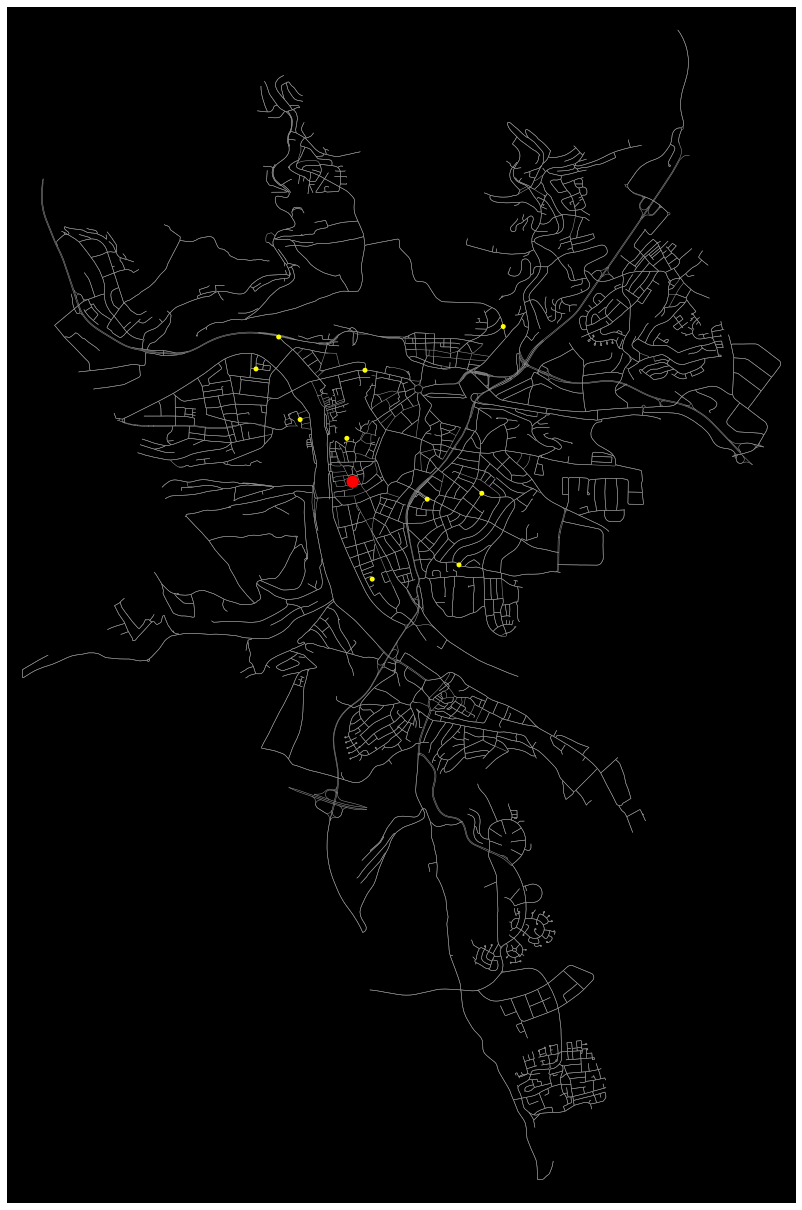

In [34]:
# First show the potential DCs and Customers
#warnings.filterwarnings("ignore")

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")


# DC Coords


#coord_DC1 = (49.794783, 9.906499)
#coord_DC2 = (49.81613668, 9.897654496)
coord_DC3 = (49.7881377, 9.9314981)
#coord_DC4 = (49.8226541, 9.9245535)
#coord_DC5 =


#DC_1 = ox.get_nearest_node(G, coord_DC1)
#DC_2 = ox.get_nearest_node(G, coord_DC2)
DC_3 = ox.get_nearest_node(G, coord_DC3)
#DC_4 = ox.get_nearest_node(G, coord_DC4)
#DC_5 = ox.get_nearest_node(G, coord_DC5)


nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

DCs = [DC_3]
#DCs = [DC_1, DC_2, DC_3, DC_4] #DC_5]

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

ns = []
for node in G.nodes():
    if node in DCs:
        ns.append(150)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
        
nc = []
for node in G.nodes():
    if node in DCs: 
        nc.append("red")
    elif node in Nodes_S:
        nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")